In [1]:
import networkx as nx
import sys
sys.path.append("../FastCover/")
import pandas as pd
from utils import *
import matplotlib.pyplot as plt

In [2]:
def getDimParams(model):
    # Returns the number of parameters needed
    sum_ = 0
    for name, param in model.named_parameters():
        m = 1
        #print(name, param.shape)
        #print(np.max(param.detach().numpy()), np.min(param.detach().numpy()))
        for n in param.shape:
            m*=n
        sum_ += m
    return sum_ 

def getStateDict(model, params):
    # reensamble the original state dict with new values
    sd = model.state_dict()
    sum_ = 0
    from_ = 0

    for name, param in model.named_parameters():
        m = 1
        for n in param.shape:
            m*=n
        #print(m)
        #print(vals[from_:from_+m].reshape(param.shape).shape)
        sd[name] = torch.tensor(params[from_:from_+m].reshape(param.shape))
        from_ += m
        #print(from_)
    return sd

def SimpleweightedCrossEntropy(y, p, w):
    return np.sum(y*(1-p)*w[0] + (1-y)*p*w[1]) / len(y)

def Func(X, MDH = False, alpha = 0.7):
    # Objective function
    
    if not MDH:
        sd = getStateDict(Models[i], X)
        Models[i].load_state_dict(sd)
    else:
        alpha = 1
        
    
    value = 0.0
    loss = 0.0
    
    for ig, data in enumerate(Graphs_Train):
        
        if MDH:
            y_pred = None
        else:
            data = data.to(device)
            y_pred = torch.exp(Models[i](data)).T[1]
        
        
        ts = len(FindMinimumTarget(graphs[ig], out = y_pred, threshold = 0.5)[0])
        
        val = ts / graphs[ig].number_of_nodes()
        
        value += val
        
        #"""
        if not MDH:
            zeros = np.zeros(data.num_nodes)
            zeros[torch.topk(y_pred, ts)[1]] = 1
            weigth_minoritaria = np.sum(zeros==0)/np.sum(zeros)
            loss += SimpleweightedCrossEntropy(zeros, y_pred.detach().numpy(), [weigth_minoritaria, 1])
        
        #"""
        
        
    
    value /= len(Graphs_Train) 
    loss /= len(Graphs_Train) 
    #return value
    
    return value * (alpha) + loss * (1 - alpha)


def getDataSet(file, file_graph, scale, remove_BC = False):
    
    G = loadGraph(file_graph)
    Features = []
    temp = []
    try:
        with open(file) as f:
            c = 0

            for line in f.readlines()[1:]:
                c+=1
                feats = np.array(line.split(","), dtype = float)
                temp.append(feats)
        temp = np.array(temp)
        if remove_BC:
            temp = np.delete(temp, 0, 1)
        Features.append(temp)
    except Exception as e:
        print(er)
        print(line)
        print(c)
        print(e)

    Graphs_Train = Convert2DataSet([G], [[]], feats = Features, scale = scale)

    return Graphs_Train

In [3]:
import torch.nn as nn
import torch_geometric.nn as geom_nn
import torch.nn.functional as F
import torch
from torch_geometric.nn import Linear

class GNN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, name_layer = "SAGE"):
        super().__init__()
        self.name = name_layer
        layer = None
        hidden_feats = 8
        
        if name_layer == "SAGE":
            layer = geom_nn.SAGEConv
            
            self.conv1 = layer(num_node_features, num_classes)
            #self.conv3 = layer(hidden_feats, num_classes)
            
        elif name_layer == "GAT":
            layer = geom_nn.GATConv
            
            self.conv1 = layer(num_node_features, num_classes)
            #self.conv3 = layer(hidden_feats, num_classes)
            
        elif name_layer == "GCN":
            layer = geom_nn.GCNConv
            
            self.conv1 = layer(num_node_features, num_classes)
            #self.conv1 = layer(num_node_features, hidden_feats)
            #self.conv3 = Linear(hidden_feats, num_classes)
            
        elif name_layer == "GraphConv":
            layer = geom_nn.GraphConv
            
            self.conv1 = layer(num_node_features, num_classes)
            
        elif name_layer == "SGConv":
            layer = geom_nn.SGConv
            
            self.conv1 = layer(num_node_features, num_classes)
            #self.conv3 = Linear(hidden_feats, num_classes)
        
        
        else:
            print("Nanais")
    
        
        #self.conv2 = layer(hidden_feats, hidden_feats)
        #self.conv3 = Linear(hidden_feats, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        #x = self.conv3(x, edge_index)
        #x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        #x = self.conv2(x, edge_index)

        #return F.log_softmax(self.conv3(x), dim=1)
        #if self.name in ['GraphConv', 'GCN', 'SAGE']:
        return F.log_softmax(x, dim=1)
        #else:
        #    return F.log_softmax(self.conv3(x), dim=1)
        

In [59]:
torch.manual_seed(13)
layers = ["SAGE"]
Models = [GNN(5, 2, name_layer = layer_name) for 
         layer_name in layers]

In [221]:
Models[0].state_dict()

OrderedDict([('conv1.lin_l.weight',
              tensor([[ 2.5814,  9.9062, -0.2403,  3.4555,  5.8306],
                      [-6.6483, -3.2255, -3.5903, -8.1770,  4.1777]])),
             ('conv1.lin_l.bias', tensor([2.3566, 5.3102])),
             ('conv1.lin_r.weight',
              tensor([[-5.8680, -3.5077, -7.0569, -0.3109,  5.1788],
                      [ 6.3263,  5.4096,  4.0347,  2.0957,  6.7210]]))])

In [61]:
ps = f"../Models/runs/scalefree/Pruebas_GA/Allfeatures/SAGE_iter_100.txt" 

params = []
with open(ps) as f:
    for line in f.readlines():
        params.append(float(line.replace("\n","")))
params = np.array(params)

In [62]:
params

array([ 2.58137524,  9.90616878, -0.24033945,  3.45550824,  5.83060793,
       -6.64832569, -3.22552829, -3.59032898, -8.1770277 ,  4.17768925,
        2.3566232 ,  5.31024302, -5.86804651, -3.50768203, -7.05690445,
       -0.31086873,  5.17875879,  6.32634986,  5.40959078,  4.03472141,
        2.09572157,  6.72101697])

In [220]:
sd = getStateDict(Models[0], params)
Models[0].load_state_dict(sd)

Models[0].state_dict()

OrderedDict([('conv1.lin_l.weight',
              tensor([[ 2.5814,  9.9062, -0.2403,  3.4555,  5.8306],
                      [-6.6483, -3.2255, -3.5903, -8.1770,  4.1777]])),
             ('conv1.lin_l.bias', tensor([2.3566, 5.3102])),
             ('conv1.lin_r.weight',
              tensor([[-5.8680, -3.5077, -7.0569, -0.3109,  5.1788],
                      [ 6.3263,  5.4096,  4.0347,  2.0957,  6.7210]]))])

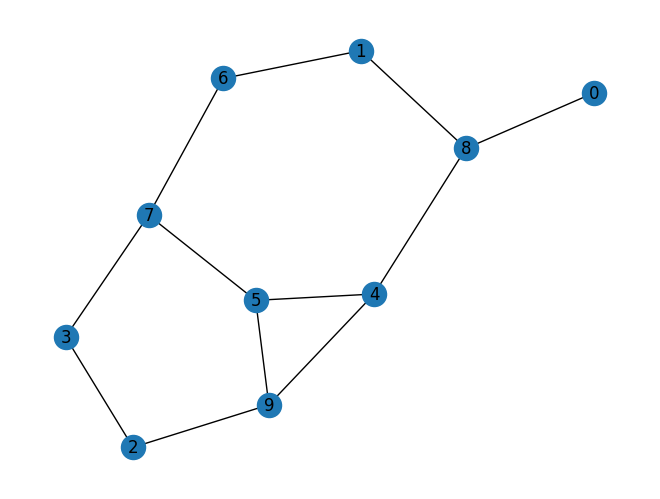

In [121]:
N = 10
p = 0.3
G = nx.erdos_renyi_graph(N, p, seed = 666)
nx.draw(G, with_labels = True)

In [141]:
def getFeatures(G):
    
    BC = np.array(list(nx.betweenness_centrality(G).values()))
    CC = np.array(list(nx.closeness_centrality(G).values()))
    #LC = np.array(list(nx.load_centrality(G).values()))
    DG = np.array(list(nx.degree(G))).T[1]
    PR = np.array(list(nx.pagerank(G).values()))
    
    EC = np.array(list(nx.eigenvector_centrality(G, max_iter=1000).values()))

    features = [BC, PR, DG, CC, EC]
    names = ["BC", "PageRank", "degree", "closeness_centrality", "E"]#, "LC"]
    return np.array(features).T, names

In [66]:
feats, _ = getFeatures(G)

In [96]:
feats[9]

array([0.        , 0.04434195, 1.        , 0.42857143, 0.14257831])

In [68]:
X = Convert2DataSet([G], [[]], feats = [feats])[0]
X

Data(edge_index=[2, 28], num_nodes=10, x=[10, 5], y=[10], num_classes=2)

In [70]:
torch.exp(Models[0](X))

tensor([[5.3062e-10, 1.0000e+00],
        [1.0039e-10, 1.0000e+00],
        [6.3014e-01, 3.6986e-01],
        [9.9693e-01, 3.0675e-03],
        [1.0000e+00, 1.4549e-07],
        [1.0000e+00, 5.2301e-07],
        [9.6215e-01, 3.7850e-02],
        [1.0000e+00, 2.0672e-06],
        [1.0000e+00, 2.0672e-06],
        [1.0000e+00, 7.0344e-11]], grad_fn=<ExpBackward0>)

In [5]:
data = pd.read_csv("./SAGE_training_Erdos_SF.csv")

Text(0, 0.5, 'Loss')

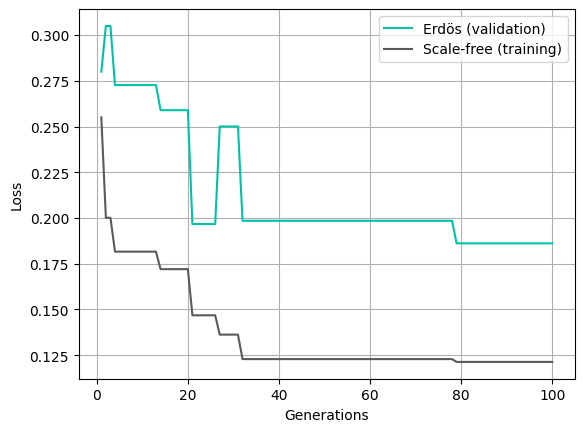

In [6]:
plt.plot(np.arange(1, 101,1), data['Erdos'], label = "Erdös (validation)", color = '#00c2a8')
plt.plot(np.arange(1, 101,1), data['Scalefree'], label = 'Scale-free (training)', color = '#5A5A5A')
plt.grid()
plt.legend()
plt.xlabel("Generations")
plt.ylabel("Loss")

In [ ]:
"""
Para el diagrama que primero del grafo entero
Después 5 grafos más pequeños que pinte de un color la importancia de cada nodo conforme a las features

después mostrar cómo se multiplican las características por las matrices, 

y al final las probabilidades asignadas por SAGE y un colorcito que diga cuáles son más importantes

Poner el ejemplo de la matriz de pesos en algún lugar que haya espacio

Pero revisar un ejemplo donde se vea el potencial de esta aplicación con pocos nodos, generar un chingo 
de grafos y quedarme si uno da una solución mejor que el mejor target set <- la clave
"""

In [147]:
for p in np.arange(0,0.5, 0.01):

    for seed in range(100):
        sage_best = [True, False]
        G = nx.erdos_renyi_graph(N, p, seed = seed)
        _, mdh = FindMinimumTarget(G, out = None)

        feats, _ = getFeatures(G)
        for f in range(5):
            _, l = FindMinimumTarget(G, out = torch.tensor(feats.T[f]))
            if l < mdh:
                print(f"Listo! por feature {f} y {p}")
                print(seed)
                sage_best[0] = False

        X = Convert2DataSet([G], [[]], feats = [feats])[0]
        torch.exp(Models[0](X))

        _, l = FindMinimumTarget(G, out = torch.tensor(torch.exp(Models[0](X)).detach().numpy().T[1]))
        if l < mdh:
                print(f"Listo! por SAGE {p}")
                print(seed)
                sage_best[1] = True
        
        if sage_best[0] * sage_best[1]:
            print(f"Ya chingamos con la seed {seed} y p {p}")
            break


Listo! por feature 1 y 0.11
44
Listo! por feature 4 y 0.12
45
Listo! por feature 4 y 0.13
45
Listo! por feature 1 y 0.15
89
Listo! por SAGE 0.15
89
Listo! por feature 4 y 0.16
46
Listo! por feature 4 y 0.16
69
Listo! por feature 1 y 0.16
89
Listo! por SAGE 0.16
89
Listo! por feature 0 y 0.17
28
Listo! por feature 1 y 0.17
28
Listo! por SAGE 0.17
28
Listo! por feature 4 y 0.17
46
Listo! por feature 1 y 0.17
89
Listo! por SAGE 0.17
89
Listo! por feature 4 y 0.18
23
Listo! por feature 4 y 0.18
46
Listo! por feature 4 y 0.18
62
Listo! por feature 1 y 0.18
89
Listo! por SAGE 0.18
89
Listo! por feature 4 y 0.19
44
Listo! por feature 4 y 0.19
46
Listo! por feature 4 y 0.19
60
Listo! por feature 4 y 0.19
62
Listo! por feature 1 y 0.19
89
Listo! por SAGE 0.19
89
Listo! por feature 4 y 0.2
44
Listo! por feature 4 y 0.2
46
Listo! por feature 4 y 0.2
60
Listo! por feature 4 y 0.2
62
Listo! por feature 4 y 0.2
71
Listo! por feature 1 y 0.2
89
Listo! por SAGE 0.2
89
Listo! por feature 4 y 0.21
44
Li

Listo! por feature 4 y 0.47000000000000003
74
Listo! por feature 1 y 0.47000000000000003
75
Listo! por feature 3 y 0.47000000000000003
75
Listo! por feature 4 y 0.47000000000000003
75
Listo! por feature 0 y 0.47000000000000003
79
Listo! por feature 1 y 0.47000000000000003
79
Listo! por SAGE 0.47000000000000003
79
Listo! por feature 0 y 0.47000000000000003
90
Listo! por feature 1 y 0.47000000000000003
97
Listo! por feature 0 y 0.48
9
Listo! por feature 1 y 0.48
9
Listo! por SAGE 0.48
9
Listo! por feature 1 y 0.48
15
Listo! por SAGE 0.48
15
Listo! por feature 0 y 0.48
38
Listo! por feature 1 y 0.48
38
Listo! por SAGE 0.48
38
Listo! por feature 0 y 0.48
42
Listo! por feature 1 y 0.48
42
Listo! por SAGE 0.48
42
Listo! por feature 0 y 0.48
44
Listo! por feature 1 y 0.48
44
Listo! por SAGE 0.48
44
Listo! por feature 0 y 0.48
49
Listo! por feature 4 y 0.48
49
Listo! por feature 3 y 0.48
50
Listo! por feature 4 y 0.48
50
Listo! por feature 4 y 0.48
51
Listo! por SAGE 0.48
51
Listo! por feature

3 [0, 3, 6]
3 [0, 3, 4]
3 [0, 3, 4]
3 [0, 3, 6]
3 [0, 6, 7]
2 [0, 4]


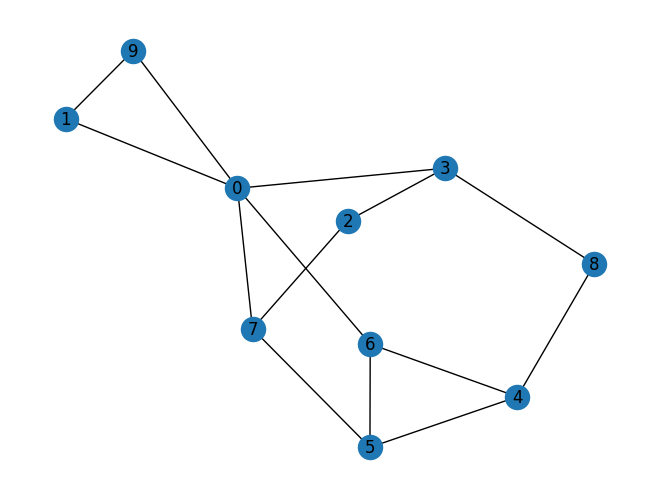

In [233]:
G = nx.erdos_renyi_graph(N, p = 0.35, seed = 49)
nx.draw(G, with_labels = True)

feats, _ = getFeatures(G)
for f in range(5):
    ts, l = FindMinimumTarget(G, out = torch.tensor(feats.T[f]))
    print(l, ts)

X = Convert2DataSet([G], [[]], feats = [feats])[0]
torch.exp(Models[0](X))

ts, l = FindMinimumTarget(G, out = torch.tensor(torch.exp(Models[0](X)).detach().numpy().T[1]))
print(l, ts)

In [218]:
def Scale(X):
    return (X - np.min(X, axis = 0)) / (np.max(X, axis = 0) - np.min(X, axis = 0))

X_ = np.append(feats, np.expand_dims(torch.exp(Models[0](X)).detach().numpy(), 0).T[1], axis = 1)
Data = pd.DataFrame(Scale(X_))
Data.columns = ["BC", "PageRank", "degree", "closeness", "Eigenvector", "SAGE"]
Data

,BC,PageRank,degree,closeness,Eigenvector,SAGE
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.000000,0.007799,0.000000,0.000000,0.158119,0.000000
2,0.061905,0.000000,0.000000,0.000000,0.050428,0.000029
3,0.400000,0.346198,0.333333,0.464286,0.339784,0.912643
4,0.147619,0.323822,0.333333,0.206349,0.339032,0.978252
5,0.152381,0.304974,0.333333,0.206349,0.461053,0.436479
6,0.271429,0.296323,0.333333,0.464286,0.587099,0.007892
7,0.323810,0.318258,0.333333,0.464286,0.491888,0.243448
8,0.100000,0.001579,0.000000,0.097744,0.000000,0.000308
9,0.000000,0.007799,0.000000,0.000000,0.158119,0.000000


In [219]:
Data.to_csv("ExampleGraphPaper.csv")

In [106]:
def FindMinimumTarget(G, out = None, threshold = 0.5, print_ = False):
    """
    in:
    G - networkx
    out - probabilities from torch
    threshold = 0.5 - umbral de infección
    if out = None --> MDH
    """
    Isolates = list(nx.isolates(G))
    Solution = Isolates
    n = len(G.nodes())
    
    
    Num_Neighs = np.array(nx.degree(G)).T[1]
    Num_Neighs_Infected = np.zeros(n, dtype = "int16")
    Can_Sum = np.ones(n, dtype = "int16")
    
    Can_Sum[Isolates] = 0
    
    Infected = np.zeros(n, dtype = "int16")
    Infected[Isolates] = 1
    
    if out == None:
        out_ = Num_Neighs.copy()
    else:
        out_ = out.detach().numpy().copy()
    
    Order_Node_Degree = np.argsort(-out_)
    
    for i in range(n):
        Inf = Order_Node_Degree[i]

        if Infected[Inf] == 1:
            continue
        
        Solution.append(Inf)
        Infected[Inf] = 1
        
        # Modifica todas los vectores Infected, Num_Neighs_Infected y Can_Sum por su ubicación en memoria
        Sol, P = CheckInfect(G, Infected, Num_Neighs, Num_Neighs_Infected, Can_Sum, n,  threshold = threshold)
        
        if Sol:
            break
    if print_:
        print(f"1.00 Infected")
        print()
    return Solution, len(Solution)